<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/OSA/GA_FFNN_OSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

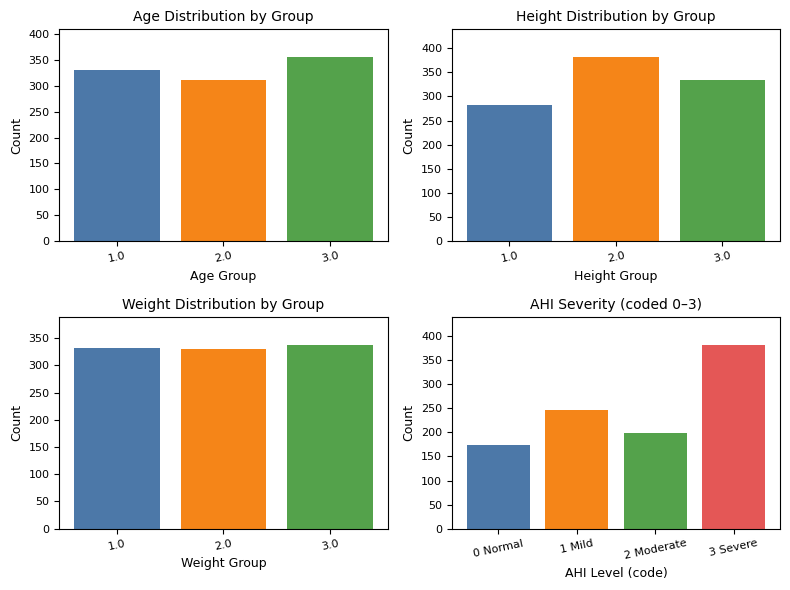

In [33]:
# --- Read corrected CSV and plot 2x2 input distributions (Age, Height, Weight, AHI) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Load ----------
df = pd.read_csv("OSA_Data_with_AHILevels.csv")

# ---------- Palette ----------
palette = ["#4C78A8", "#F58518", "#54A24B", "#E45756"]

# ---------- Helper: bar plot on a given axis ----------
def bar_on_ax(ax, series, title, xlabel, ylabel, order=None, ticklabels=None, colors=None):
    s = series.dropna()
    if order is None:
        try:
            order = sorted(pd.unique(s))
        except Exception:
            order = list(s.value_counts().index)
    counts = s.value_counts().reindex(order).fillna(0).astype(int)

    x = np.arange(len(order))
    ax.bar(x, counts.values, color=(colors[:len(order)] if colors else None))
    ax.set_xticks(x)
    ax.set_xticklabels(ticklabels if ticklabels else [str(v) for v in order], rotation=12, fontsize=8)
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.set_title(title, fontsize=10)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_ylim(0, max(1, counts.values.max() * 1.15))

# ---------- Prepare AHI severity series (coded 0..3) ----------
ahi_code_order  = [0, 1, 2, 3]
ahi_code_labels = ["0 Normal", "1 Mild", "2 Moderate", "3 Severe"]

def get_ahi_code_series(df):
    # Prefer precomputed codes if available
    if "AHI_Level_Code" in df.columns:
        return df["AHI_Level_Code"].astype("Int64"), ahi_code_order, ahi_code_labels

    # Else inspect AHI (may be codes 0..3 or raw events/hour)
    if "AHI" in df.columns:
        ahi_num = pd.to_numeric(df["AHI"], errors="coerce")
        uniq = set(ahi_num.dropna().unique().tolist())
        if uniq.issubset({0, 1, 2, 3}) and (ahi_num.max() <= 3):
            return ahi_num.astype("Int64"), ahi_code_order, ahi_code_labels
        # Raw events/hour → bin to codes
        bins  = [-np.inf, 5, 15, 30, np.inf]   # [a,b)
        codes = [0, 1, 2, 3]
        ahi_codes = pd.cut(
            ahi_num, bins=bins, labels=codes,
            right=False, include_lowest=True, ordered=True
        ).astype("Int64")
        return ahi_codes, ahi_code_order, ahi_code_labels

    raise KeyError("No AHI or AHI_Level_Code column found in the dataset.")

ahi_series, ahi_order, ahi_labels = get_ahi_code_series(df)

# ---------- Build 2x2 subplots ----------
fig, axes = plt.subplots(2, 2, figsize=(8.0, 6.0))
axes = axes.ravel()

# Age
if "Age" in df.columns:
    order_age = sorted(pd.unique(df["Age"].dropna()))
    bar_on_ax(
        axes[0], df["Age"],
        title="Age Distribution by Group",
        xlabel="Age Group",
        ylabel="Count",
        order=order_age,
        ticklabels=[str(x) for x in order_age],
        colors=palette,
    )
else:
    axes[0].axis("off")

# Height
if "Height" in df.columns:
    order_height = sorted(pd.unique(df["Height"].dropna()))
    bar_on_ax(
        axes[1], df["Height"],
        title="Height Distribution by Group",
        xlabel="Height Group",
        ylabel="Count",
        order=order_height,
        ticklabels=[str(x) for x in order_height],
        colors=palette,
    )
else:
    axes[1].axis("off")

# Weight
if "Weight" in df.columns:
    order_weight = sorted(pd.unique(df["Weight"].dropna()))
    bar_on_ax(
        axes[2], df["Weight"],
        title="Weight Distribution by Group",
        xlabel="Weight Group",
        ylabel="Count",
        order=order_weight,
        ticklabels=[str(x) for x in order_weight],
        colors=palette,
    )
else:
    axes[2].axis("off")

# AHI Severity (coded 0..3)
bar_on_ax(
    axes[3], ahi_series,
    title="AHI Severity (coded 0–3)",
    xlabel="AHI Level (code)",
    ylabel="Count",
    order=ahi_order,
    ticklabels=ahi_labels,
    colors=palette,
)

fig.tight_layout()

# ---------- Display and Save ----------
plt.show()
fig.savefig("osa_input_distribution.png", dpi=200, bbox_inches="tight")
# If you strictly want the name without extension, also do:
# fig.savefig("osa_input_distribution", dpi=200, bbox_inches="tight")
plt.close(fig)


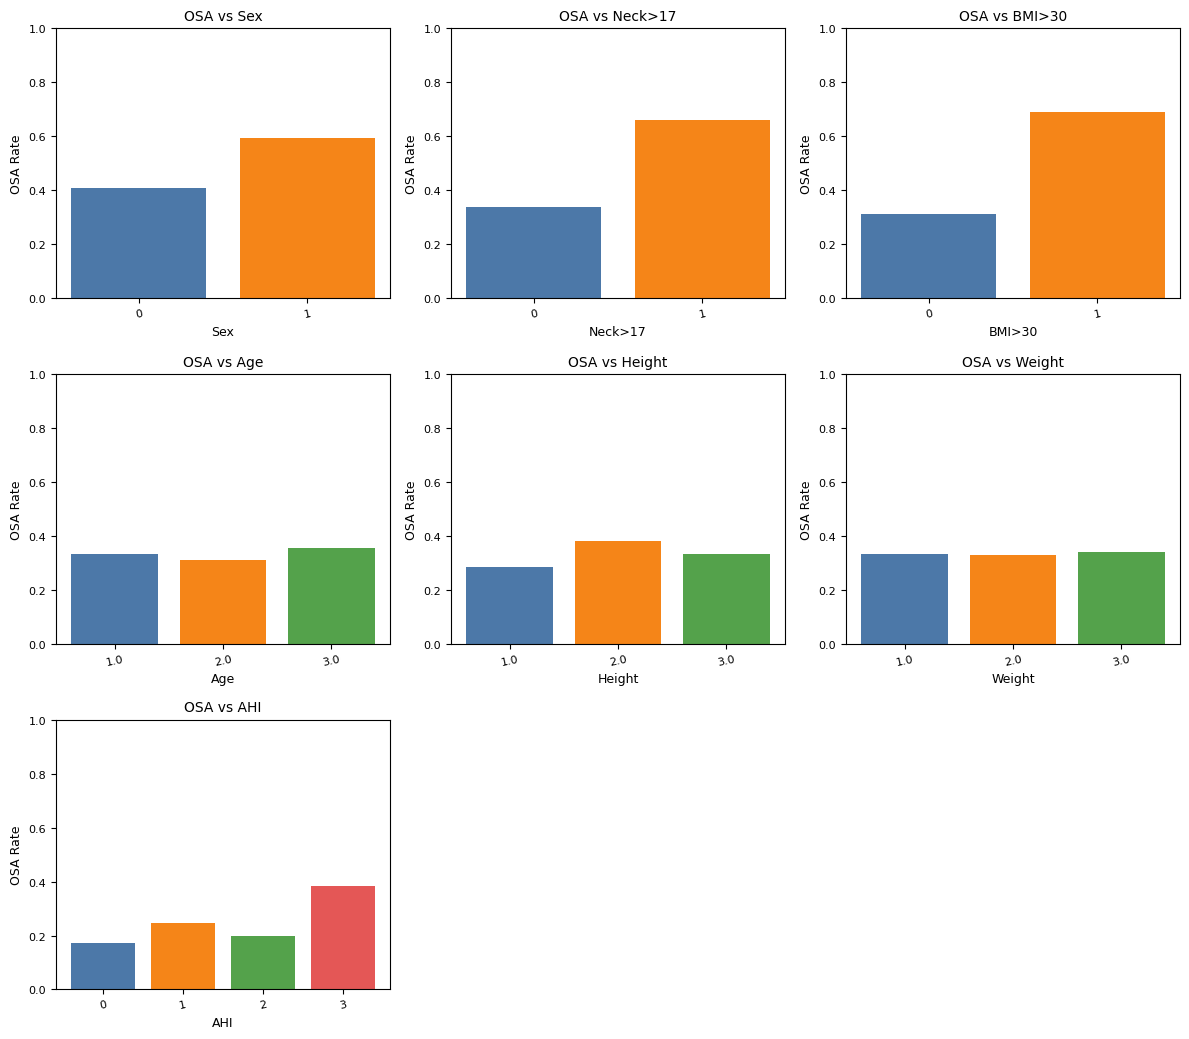

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming df is already loaded with AHI coded levels (0–3) and grouped features
# e.g., df = pd.read_csv("OSA_Data_with_AHILevels.csv")

# Features to compare with OSA
features = ["Sex", "Neck>17", "BMI>30", "Age", "Height", "Weight", "AHI"]

# Custom color palette
bar_colors = ["#4C78A8", "#F58518", "#54A24B", "#E45756"]

# Set up subplots (adjust rows/cols dynamically)
n_features = len(features)
ncols = 3
nrows = int(np.ceil(n_features / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.5 * nrows))
axes = axes.flatten()

for i, feature in enumerate(features):
    if feature not in df.columns:
        continue

    # Calculate OSA prevalence per category (mean of OSA column)
    if "OSA" in df.columns:
        means = df.groupby(feature)["OSA"].mean()
    else:
        # fallback: frequency distribution if OSA col missing
        means = df[feature].value_counts(normalize=True).sort_index()

    x_labels = means.index.astype(str)
    y_values = means.values

    axes[i].bar(np.arange(len(x_labels)), y_values,
                color=bar_colors[:len(x_labels)])
    axes[i].set_title(f"OSA vs {feature}", fontsize=10)
    axes[i].set_xlabel(feature, fontsize=9)
    axes[i].set_ylabel("OSA Rate", fontsize=9)
    axes[i].set_xticks(np.arange(len(x_labels)))
    axes[i].set_xticklabels(x_labels, fontsize=8, rotation=12)
    axes[i].tick_params(axis='y', labelsize=8)
    axes[i].set_ylim(0, 1)

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

# Save figure
fig.savefig("osa_relationship_bars.png", dpi=200, bbox_inches="tight")
plt.close(fig)


In [47]:
"""
GA-ANN Multi-Class Classifier for AHI (0,1,2,3)
-----------------------------------------------
- Input: OSA_Data_with_AHILevels.csv
- Target: 'AHI' (classes 0..3)
- X: all other numeric columns (exclude 'AHI')

Pipeline:
1) Load + preprocess (median impute X, MinMax scale, 80/20 stratified split)
2) GA-optimized 1-hidden-layer NN (tanh -> softmax(4)), fitness = weighted CCE on TRAIN
3) Evaluate: accuracy + classification report
4) Plots (saved):
   - cm_train_test_multiclass.png  (side-by-side 4x4 CMs)
   - roc_multiclass_test.png       (per-class + micro/macro ROC on TEST)
   - ga_progress.png               (best/avg CCE + best/avg MSE)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, auc
)

# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED       = 23
TEST_SIZE         = 0.20
HIDDEN_SIZE       = 30
POP_SIZE          = 300
GENERATIONS       = 300
ELITE_COUNT       = 12
MUTATION_RATE     = 0.03
MUTATION_STD      = 0.06
WEIGHT_INIT_RANGE = 2.5
WEIGHT_CLIP       = 2.0
INPUT_CSV         = "OSA_Data_with_AHILevels.csv"

EARLY_STOP        = True
PATIENCE_GENS     = 30
IMPROVE_EPS       = 1e-5   # <-- correct name

np.random.seed(RANDOM_SEED)

# -----------------------------
# Math helpers
# -----------------------------
def softmax(Z: np.ndarray) -> np.ndarray:
    Z = np.clip(Z, -50, 50)
    Zmax = Z.max(axis=1, keepdims=True)
    e = np.exp(Z - Zmax)
    p = e / np.clip(e.sum(axis=1, keepdims=True), 1e-12, None)
    return p

def weighted_cce(y_true_oh: np.ndarray, y_prob: np.ndarray, class_weights: np.ndarray, eps: float = 1e-12) -> float:
    """
    Weighted Categorical Cross-Entropy:
      L = - mean_i sum_k w_k * y_{ik} * log(p_{ik})
    y_true_oh: (n, K) one-hot
    y_prob:    (n, K) softmax probabilities
    class_weights: (K,)
    """
    p = np.clip(y_prob, eps, 1 - eps)
    w = class_weights.reshape(1, -1)
    loss = -np.mean((y_true_oh * w) * np.log(p))
    return float(loss)

def multiclass_mse(y_true_oh: np.ndarray, y_prob: np.ndarray) -> float:
    return float(np.mean((y_true_oh - y_prob) ** 2))

# -----------------------------
# Load & preprocess
# -----------------------------
df = pd.read_csv(INPUT_CSV)
assert "AHI" in df.columns, "Column 'AHI' not found. Expect AHI classes {0,1,2,3}."

y = pd.to_numeric(df["AHI"], errors="coerce").astype(int).values
assert set(np.unique(y)).issubset({0,1,2,3}), "AHI must be in {0,1,2,3}."

# Features: numeric columns except 'AHI'
X_df = df.drop(columns=["AHI"]).select_dtypes(include=[np.number])
X = X_df.values.astype(float)

# Impute & scale
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imp)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

num_classes = 4
INPUT_SIZE  = X_train.shape[1]
H           = int(HIDDEN_SIZE)
OUTPUT_SIZE = num_classes

# Class weights: total/(K * count_k), normalized to mean 1.0
counts = np.bincount(y_train, minlength=num_classes).astype(float)
counts[counts == 0] = 1.0
class_weights = (len(y_train) / (num_classes * counts))
class_weights = class_weights / class_weights.mean()

# One-hot labels
Y_train_oh = np.eye(num_classes)[y_train]
Y_test_oh  = np.eye(num_classes)[y_test]

# -----------------------------
# GA chromosome layout
# -----------------------------
WEIGHT_SIZE = (INPUT_SIZE * H) + H + (H * OUTPUT_SIZE) + OUTPUT_SIZE

def unflatten_weights(w: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    idx = 0
    W1 = w[idx: idx + INPUT_SIZE * H].reshape((INPUT_SIZE, H)); idx += INPUT_SIZE * H
    b1 = w[idx: idx + H].reshape((1, H));                                idx += H
    W2 = w[idx: idx + H * OUTPUT_SIZE].reshape((H, OUTPUT_SIZE));        idx += H * OUTPUT_SIZE
    b2 = w[idx:].reshape((1, OUTPUT_SIZE))
    return W1, b1, W2, b2

def forward_pass(Xb: np.ndarray, wvec: np.ndarray) -> np.ndarray:
    Xb = np.nan_to_num(Xb, nan=0.0, posinf=0.0, neginf=0.0)
    W1, b1, W2, b2 = unflatten_weights(wvec)
    h = np.tanh(Xb @ W1 + b1)
    logits = h @ W2 + b2
    probs = softmax(logits)  # (n, K)
    return np.nan_to_num(probs, nan=1.0/num_classes, posinf=1.0, neginf=0.0)

# -----------------------------
# GA ops
# -----------------------------
def init_population(pop_size: int, dim: int) -> np.ndarray:
    return np.random.uniform(-WEIGHT_INIT_RANGE, WEIGHT_INIT_RANGE, size=(pop_size, dim))

def evaluate_population(pop: np.ndarray, Xb: np.ndarray, Yb_oh: np.ndarray):
    cces = np.empty(pop.shape[0], dtype=float)
    mses = np.empty(pop.shape[0], dtype=float)
    for i, ind in enumerate(pop):
        Yp = forward_pass(Xb, ind)
        cces[i] = weighted_cce(Yb_oh, Yp, class_weights)
        mses[i] = multiclass_mse(Yb_oh, Yp)
    return cces, mses

def select_elites(pop: np.ndarray, fitness: np.ndarray, elite_count: int) -> np.ndarray:
    idx = np.argsort(fitness)[:elite_count]  # lower CCE is better
    return pop[idx].copy()

def crossover(p1: np.ndarray, p2: np.ndarray) -> np.ndarray:
    point = np.random.randint(1, p1.size)
    return np.concatenate([p1[:point], p2[point:]])

def mutate(w: np.ndarray, rate: float, std: float) -> np.ndarray:
    mask = np.random.rand(w.size) < rate
    w[mask] += np.random.normal(0.0, std, size=np.sum(mask))
    np.clip(w, -WEIGHT_CLIP, WEIGHT_CLIP, out=w)
    return w

# -----------------------------
# GA loop (with early stopping)
# -----------------------------
population = init_population(POP_SIZE, WEIGHT_SIZE)
best_cce_hist, avg_cce_hist = [], []
best_mse_hist, avg_mse_hist = [], []

best_cce = np.inf
stall = 0

for gen in range(GENERATIONS):
    cces, mses = evaluate_population(population, X_train, Y_train_oh)

    c_min, c_avg = float(np.min(cces)), float(np.mean(cces))
    m_min, m_avg = float(np.min(mses)), float(np.mean(mses))

    best_cce_hist.append(c_min); avg_cce_hist.append(c_avg)
    best_mse_hist.append(m_min); avg_mse_hist.append(m_avg)

    if c_min + IMPROVE_EPS < best_cce:   # <-- fixed typo here
        best_cce = c_min
        stall = 0
    else:
        stall += 1
        if EARLY_STOP and stall >= PATIENCE_GENS:
            break

    elites = select_elites(population, cces, ELITE_COUNT)

    new_pop = [elites[i % ELITE_COUNT].copy() for i in range(ELITE_COUNT)]
    while len(new_pop) < POP_SIZE:
        i1, i2 = np.random.choice(ELITE_COUNT, 2, replace=False)
        child = crossover(elites[i1], elites[i2])
        child = mutate(child, MUTATION_RATE, MUTATION_STD)
        new_pop.append(child)
    population = np.vstack(new_pop)

# Best individual
final_cces, final_mses = evaluate_population(population, X_train, Y_train_oh)
best_idx = int(np.argmin(final_cces))
best_weights = population[best_idx].copy()

In [49]:
# -----------------------------
# Predictions & metrics
# -----------------------------
Yp_train = forward_pass(X_train, best_weights)        # (n, 4)
Yp_test  = forward_pass(X_test,  best_weights)

y_pred_train = np.argmax(Yp_train, axis=1)
y_pred_test  = np.argmax(Yp_test,  axis=1)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test,  y_pred_test)

print("\n=== Accuracy ===")
print(f"Train: {acc_train:.4f}  |  Test: {acc_test:.4f}")

print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred_test, digits=4))


=== Accuracy ===
Train: 0.4650  |  Test: 0.3450

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.3056    0.3143    0.3099        35
           1     0.2500    0.1837    0.2118        49
           2     0.1613    0.1250    0.1408        40
           3     0.4536    0.5789    0.5087        76

    accuracy                         0.3450       200
   macro avg     0.2926    0.3005    0.2928       200
weighted avg     0.3194    0.3450    0.3276       200



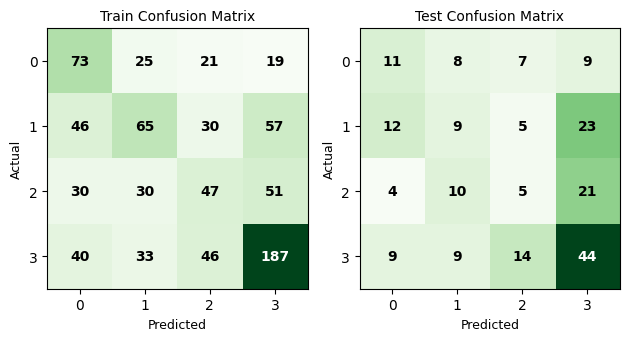

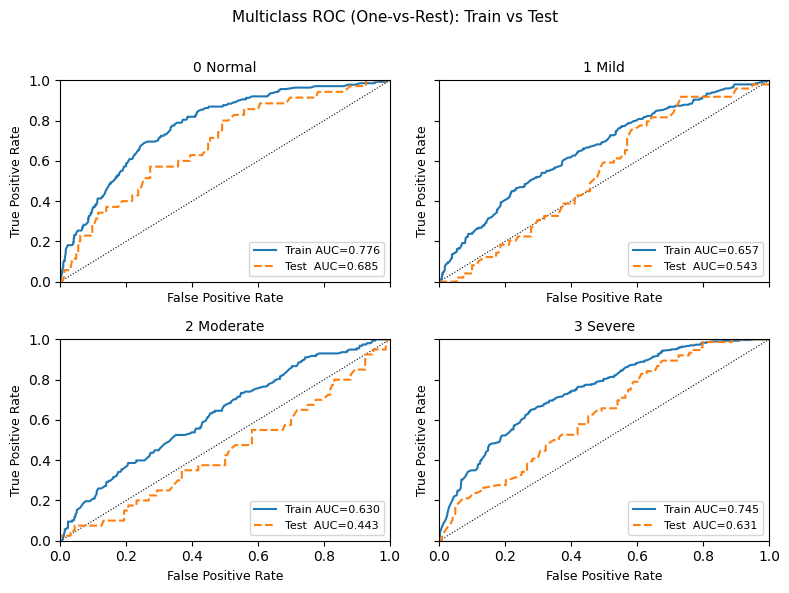

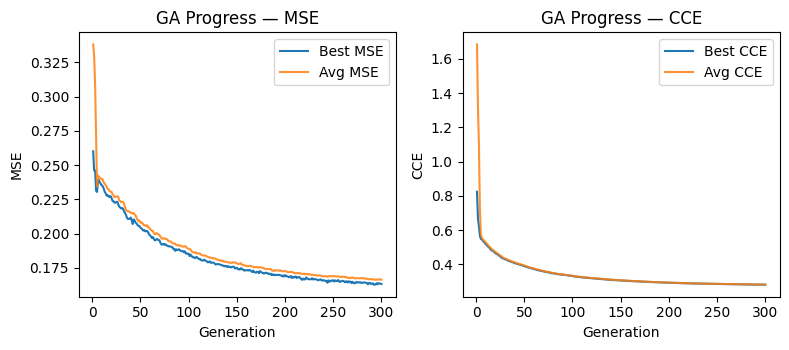

In [55]:
# -----------------------------
# Plots (Multiclass: 4 classes)
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_confusions_4x4(cm_train, cm_test, labels=("0","1","2","3"),
                        filename="cm_train_test_multiclass.png"):
    """Side-by-side 4x4 confusion matrices (Train, Test). Always saves figure."""
    fig, axes = plt.subplots(1, 2, figsize=(6.4, 3.6))
    for ax, cm, title in zip(axes, (cm_train, cm_test), ("Train", "Test")):
        im = ax.imshow(cm, cmap="Greens")
        ax.set_title(f"{title} Confusion Matrix", fontsize=10)
        ax.set_xlabel("Predicted", fontsize=9); ax.set_ylabel("Actual", fontsize=9)
        ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels); ax.set_yticklabels(labels)

        vmax = cm.max() if cm.size else 1
        for i in range(len(labels)):
            for j in range(len(labels)):
                val = int(cm[i, j])
                color = "white" if vmax > 0 and val >= 0.6 * vmax else "black"
                ax.text(j, i, str(val), ha="center", va="center",
                        fontsize=10, weight="bold", color=color)
    fig.tight_layout()
    fig.savefig(filename, dpi=200, bbox_inches="tight")
    plt.show(); plt.close(fig)

def plot_roc_multiclass_train_test_grid(
    y_train, Yp_train, y_test, Yp_test,
    n_classes=4, class_names=None,
    figsize=(8.0, 6.0), filename="roc_multiclass_train_test.png"
):
    """
    Per-class ROC in a 2x2 grid (one-vs-rest), overlaying Train (solid) and Test (dashed).
    Always saves figure.
    """
    # Binarize labels
    Ytr_oh = label_binarize(y_train, classes=list(range(n_classes)))
    Yte_oh = label_binarize(y_test,  classes=list(range(n_classes)))

    if class_names is None:
        class_names = [f"Class {k}" for k in range(n_classes)]

    fpr_tr, tpr_tr, auc_tr = {}, {}, {}
    fpr_te, tpr_te, auc_te = {}, {}, {}
    valid_tr = [True]*n_classes
    valid_te = [True]*n_classes

    for k in range(n_classes):
        # Train ROC (guard for single-class edge cases)
        yk_tr = Ytr_oh[:, k]; pk_tr = Yp_train[:, k]
        if yk_tr.sum() == 0 or yk_tr.sum() == len(yk_tr):
            fpr_tr[k], tpr_tr[k], auc_tr[k] = None, None, np.nan
            valid_tr[k] = False
        else:
            fpr_tr[k], tpr_tr[k], _ = roc_curve(yk_tr, pk_tr)
            auc_tr[k] = auc(fpr_tr[k], tpr_tr[k])

        # Test ROC
        yk_te = Yte_oh[:, k]; pk_te = Yp_test[:, k]
        if yk_te.sum() == 0 or yk_te.sum() == len(yk_te):
            fpr_te[k], tpr_te[k], auc_te[k] = None, None, np.nan
            valid_te[k] = False
        else:
            fpr_te[k], tpr_te[k], _ = roc_curve(yk_te, pk_te)
            auc_te[k] = auc(fpr_te[k], tpr_te[k])

    # 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey=True)
    axes = axes.ravel()

    for k, ax in enumerate(axes[:n_classes]):
        ax.plot([0, 1], [0, 1], "k:", linewidth=0.8)

        if valid_tr[k]:
            ax.plot(fpr_tr[k], tpr_tr[k], label=f"Train AUC={auc_tr[k]:.3f}")
        else:
            ax.text(0.5, 0.60, "No train ROC\n(1 class only)", ha="center", va="center", fontsize=8)

        if valid_te[k]:
            ax.plot(fpr_te[k], tpr_te[k], linestyle="--", label=f"Test  AUC={auc_te[k]:.3f}")
        else:
            ax.text(0.5, 0.40, "No test ROC\n(1 class only)", ha="center", va="center", fontsize=8)

        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.set_title(class_names[k], fontsize=10)
        ax.set_xlabel("False Positive Rate", fontsize=9)
        ax.set_ylabel("True Positive Rate", fontsize=9)
        ax.legend(loc="lower right", fontsize=8)

    # Hide any unused axes (if n_classes < 4)
    for ax in axes[n_classes:]:
        ax.axis("off")

    fig.suptitle("Multiclass ROC (One-vs-Rest): Train vs Test", fontsize=11)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.savefig(filename, dpi=200, bbox_inches="tight")
    plt.show(); plt.close(fig)

def plot_ga_progress_dual(best_cce_hist, avg_cce_hist, best_mse_hist, avg_mse_hist,
                          figsize=(8.0, 3.6), filename="ga_progress.png"):
    """
    One figure with two subplots:
      - Left:  MSE (best & average) over generations
      - Right: CCE (best & average) over generations
    Always saves figure.
    """
    gens = np.arange(1, max(len(best_cce_hist), len(best_mse_hist)) + 1)

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=False, sharey=False)

    # Left: MSE
    ax = axes[0]
    ax.plot(gens[:len(best_mse_hist)], best_mse_hist, label="Best MSE")
    ax.plot(gens[:len(avg_mse_hist)],  avg_mse_hist,  label="Avg MSE", alpha=0.85)
    ax.set_xlabel("Generation"); ax.set_ylabel("MSE")
    ax.set_title("GA Progress — MSE")
    ax.legend()

    # Right: CCE
    ax = axes[1]
    ax.plot(gens[:len(best_cce_hist)], best_cce_hist, label="Best CCE")
    ax.plot(gens[:len(avg_cce_hist)],  avg_cce_hist,  label="Avg CCE", alpha=0.85)
    ax.set_xlabel("Generation"); ax.set_ylabel("CCE")
    ax.set_title("GA Progress — CCE")
    ax.legend()

    fig.tight_layout()
    fig.savefig(filename, dpi=200, bbox_inches="tight")
    plt.show(); plt.close(fig)

# -----------------------------
# Make the plots (always save)
# -----------------------------
# Confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train, labels=[0,1,2,3])
cm_test  = confusion_matrix(y_test,  y_pred_test,  labels=[0,1,2,3])
plot_confusions_4x4(cm_train, cm_test, labels=("0","1","2","3"),
                    filename="cm_train_test_multiclass.png")

# ROC curves: Train vs Test (per class, 2x2)
severity_labels = ["0 Normal", "1 Mild", "2 Moderate", "3 Severe"]
plot_roc_multiclass_train_test_grid(
    y_train, Yp_train,
    y_test,  Yp_test,
    n_classes=4,
    class_names=severity_labels,
    filename="roc_multiclass_train_test.png"
)

# GA Progress (dual subplot: MSE & CCE)
plot_ga_progress_dual(best_cce_hist, avg_cce_hist, best_mse_hist, avg_mse_hist,
                      filename="ga_progress.png")


In [60]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def overall_metrics_simple(y_true, y_pred):
    """Overall (micro) metrics for single-label multiclass."""
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", zero_division=0
    )
    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Support": len(y_true),
    }

# Compute for Train and Test
train_overall = overall_metrics_simple(y_train, y_pred_train)
test_overall  = overall_metrics_simple(y_test,  y_pred_test)

overall_tbl = pd.DataFrame([train_overall, test_overall], index=["Train", "Test"])
overall_tbl = overall_tbl[["Accuracy", "Precision", "Recall", "F1", "Support"]].round(4)

print("\n=== Overall Metrics (Train & Test) ===")
overall_tbl


=== Overall Metrics (Train & Test) ===


,Accuracy,Precision,Recall,F1,Support
Train,0.465,0.465,0.465,0.465,800
Test,0.345,0.345,0.345,0.345,200
